In [35]:
import pandas as pd 
import numpy as np 

from cleaning_data import process_data


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [36]:
b_stats , summary_stats = process_data()

print(f"Data for {summary_stats['Player Name'].unique().shape[0]} players has been processed") 


Data for 2612 players has been processed


This model will take as input the summary statistics of a player at the minor leage level and will seek to predict the total amount of games played in the major leagues 

In [37]:

#Grab only the cumulitative majors and minors data to predict the majors using the minors. 
foo = summary_stats.copy().groupby(['Player Name']).head(2).reset_index(drop=True)

#Eliminate foreign league entries
data = foo[foo['Lev'] != "Foreign"]

#check to see that every datapoint has both a major and a minor 
_majminoMask = data["Player Name"].value_counts() > 1
tmp_names =  _majminoMask[_majminoMask].index.to_list()
data = data[data["Player Name"].isin(tmp_names)].reset_index(drop=True)

data["H"].dtype
bar = pd.to_numeric(data["H"] , errors="coerce")

#changed_values = data[data["H"] != bar]
#bar.dtype
# Print the changed values
#print("\nChanged Values:")
#print(changed_values)


#Convert the data entries of 2nd column forward to numerical value
print(data)

numeric_data = data.iloc[ : , 2: ].map(lambda x: pd.to_numeric(x)) #Start at the 2nd column 

          Player Name     Lev     G     PA    AB     R     H   2B  3B   HR  \
0          Wade Boggs  Majors  2440  10740  9180  1513  3010  578  61  118   
1          Wade Boggs  Minors   662   2680  2277   333   724  112   8    9   
2        Dwight Evans  Majors  2606  10569  8996  1470  2446  483  73  385   
3        Dwight Evans  Minors   404   1624  1353   235   390   60  25   37   
4       Kirby Puckett  Majors  1783   7831  7244  1071  2304  414  57  207   
...               ...     ...   ...    ...   ...   ...   ...  ...  ..  ...   
5213  Mark Kolozsvary  Minors   352   1294  1103   156   231   59   3   27   
5214   José Rodríguez  Majors     1      0     0     1     0    0   0    0   
5215   José Rodríguez  Minors   465   2080  1940   317   547   96  18   61   
5216       Nick Solak  Majors   255    974   865   118   218   35   3   21   
5217       Nick Solak  Minors   700   2968  2551   446   737  124  13   89   

      ...    BA   OBP   SLG   OPS    TB  GDP HBP  SH  SF  IBB  

In [38]:
def obp(hits , bb , hbp, ab ,sf):
    if ab + bb + hbp + sf == 0: 
        print("Error due to division by 0")
    return (hits +  bb + hbp)/(ab + bb + hbp + sf)

def slg(hits  ,b2, b3 , hr , ab): 

    if ab == 0: 
        print("Error due to division by 0")
    
    return (hits - b2 -b3  + 2*b2 +  3*b3 + 4*hr)/(ab)

def ba( hits, ab ) : 

    if ab == 0: 
        print("Error due to division by 0")

    return (hits/ab)


def na_cleaner(df : pd.DataFrame): 


    #Drop unused statistics 
    tmp = df.drop(["IBB" , "GDP" , "OPS" , "TB"], axis= 1)
    
    #Check for na_values
    features_with_nan = na_check(tmp)

    if len(features_with_nan) > 0 :

        obp_nan_mask = tmp["OBP"].isna()
        slg_nan_mask = tmp["SLG"].isna()
        ba_nan_mask = tmp["BA"].isna()

        tmp.loc[obp_nan_mask, "OBP"] = tmp.loc[obp_nan_mask].apply(
        lambda x: obp(x["H"], x["BB"], x["HBP"], x["AB"], x["SF"]),
        axis=1
        )

        tmp.loc[slg_nan_mask, "SLG"] = tmp.loc[slg_nan_mask].apply(
        lambda x: slg(x["H"], x["BB"], x["HBP"], x["AB"], x["SF"]),
        axis=1
        )   

        tmp.loc[ba_nan_mask, "BA"] = tmp.loc[ba_nan_mask].apply(
        lambda x: ba(x["H"], x["AB"]),
        axis=1
        )

        features_with_nan =na_check(tmp) #if na, then big L 4 us 

        if (len(features_with_nan) > 0): 
            tmp.fillna(0, inplace=True)

        return tmp
    return tmp


def na_check(df : pd.DataFrame): 

    features_with_nan  = {}
    for feature in df.columns: 
        has_nan = df[feature].isna().any()
        print(f"{feature} has NaN values: {has_nan}")
        if has_nan: 
            num_of_nans = df[feature].isna().sum()
            features_with_nan[feature] = num_of_nans
            print(f"    {feature} has {num_of_nans} nans")

    
    

    return features_with_nan


#def na_fixer(df : pd.DataFrame ):

    

#    df.fillna(0, inplace=True)

    #Discard any remaining na on the BA OBP SLG columns
    #if len( features_with_nan) > 0 :
   #     na_mask  = tmp["BA"].isna() | tmp["OBP"].isna() | tmp["SLG"].isna()
    #    na_index =  df[na_mask]["G"].index 
#
    #    final_data = tmp.drop(na_index)  #Take out all the players who have one or more rows with NAdata

   # return final_data


In [39]:
numeric_data_cleaned = na_cleaner(numeric_data)

numeric_data_cleaned

G has NaN values: False
PA has NaN values: False
AB has NaN values: False
R has NaN values: False
H has NaN values: False
2B has NaN values: False
3B has NaN values: False
HR has NaN values: False
RBI has NaN values: False
SB has NaN values: False
CS has NaN values: False
BB has NaN values: False
SO has NaN values: False
BA has NaN values: True
    BA has 36 nans
OBP has NaN values: True
    OBP has 37 nans
SLG has NaN values: True
    SLG has 36 nans
HBP has NaN values: False
SH has NaN values: False
SF has NaN values: False
Error due to division by 0
Error due to division by 0
Error due to division by 0
G has NaN values: False
PA has NaN values: False
AB has NaN values: False
R has NaN values: False
H has NaN values: False
2B has NaN values: False
3B has NaN values: False
HR has NaN values: False
RBI has NaN values: False
SB has NaN values: False
CS has NaN values: False
BB has NaN values: False
SO has NaN values: False
BA has NaN values: True
    BA has 1 nans
OBP has NaN values: Tr

/var/folders/y1/wk4cryk10gs66qhp2q7w_4n40000gn/T/ipykernel_94092/2857841401.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return (hits +  bb + hbp)/(ab + bb + hbp + sf)
/var/folders/y1/wk4cryk10gs66qhp2q7w_4n40000gn/T/ipykernel_94092/2857841401.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return (hits - b2 -b3  + 2*b2 +  3*b3 + 4*hr)/(ab)
/var/folders/y1/wk4cryk10gs66qhp2q7w_4n40000gn/T/ipykernel_94092/2857841401.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return (hits/ab)


,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,HBP,SH,SF
0,2440,10740,9180,1513,3010,578,61,118,1014,24,35,1412,745,0.328,0.415,0.443,23,29,96
1,662,2680,2277,333,724,112,8,9,248,29,20,366,149,0.318,0.412,0.386,8,17,12
2,2606,10569,8996,1470,2446,483,73,385,1384,78,59,1391,1697,0.272,0.370,0.470,53,52,77
3,404,1624,1353,235,390,60,25,37,238,9,7,235,281,0.288,0.394,0.452,12,5,19
4,1783,7831,7244,1071,2304,414,57,207,1085,134,76,450,965,0.318,0.360,0.477,56,23,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5213,352,1294,1103,156,231,59,3,27,123,7,4,128,373,0.209,0.322,0.342,56,3,4
5214,1,0,0,1,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0,0,0
5215,465,2080,1940,317,547,96,18,61,253,136,37,115,341,0.282,0.324,0.444,10,4,11
5216,255,974,865,118,218,35,3,21,93,19,8,74,197,0.252,0.328,0.372,26,3,6


In [40]:
#numeric_data[ba_nan_mask]

#Discard any remaining na on the BA OBP SLG columns

#na_mask  = numeric_data["BA"].isna() | numeric_data["OBP"].isna() | numeric_data["SLG"].isna()
#numeric_data
#(data[na_mask]["Player Name"])  # 
#na_index =  data[na_mask]["Player Name"].index 
#print(len(data[na_mask]["Player Name"]))
#final_data = numeric_data.drop(na_index)#Take out all the players who have one or more rows with NAdat


In [41]:

#Splitting dataframe into minor and majors  

Majors = numeric_data_cleaned.iloc[::2] # Select rows with even indices/drop given columns 
Minors = numeric_data_cleaned.iloc[1::2] # Select rows with odd indices/drop given columns

#Minors
#Majors 
#data

X = Minors.copy().reset_index(drop=True) 
Y=  Majors.copy().reset_index(drop=True) 

trainingX = X.sample(n = 2200, random_state=1)

trainingY = Y.loc[trainingX.index]

testingX = X.drop(trainingX.index)

testingY = Y.drop(trainingX.index)



#Majors
#Minors


In [42]:
testingX
trainingY

#md1_data_std = model1_data.apply(lambda x: (x - x.mean()) / x.std(), axis=0) 
#md1_data_std =md1_data_std.apply(lambda x: pd.to_numeric(x, errors = 'coerce'), axis=0) 
def standardizeDataFrame(df :pd.DataFrame): 
    n_df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
    return n_df 



n_testingX = testingX.apply(lambda x: (x - x.mean()) / x.std(), axis=0) 
n_trainingX= trainingX.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
n_trainingY = trainingY.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
n_testingY = testingY.apply(lambda x: (x - x.mean()) / x.std(), axis=0) 

In [43]:
# Model 1: Lazy LinReg


models = {}

for feature in trainingX.columns: 
    name = f"lr_{feature}"
    model = LinearRegression().fit(trainingX,trainingY[feature])
    models[name] = model 


model_results = { }

for feature in trainingX.columns:
#models["lr_G"].score(testingX, testingY["G"])
    name = f"lr_{feature}"
    train_score = models[name].score(trainingX, trainingY[feature]) 
    testing_score = models[name].score(testingX , testingY[feature])
    model_results[name] = (train_score , testing_score)
#models[]
model_results

{'lr_G': (0.2902981734178115, 0.33312541247891736),
 'lr_PA': (0.30020314381952573, 0.33546305562661005),
 'lr_AB': (0.30106255328310605, 0.3365276502664908),
 'lr_R': (0.2963178721786125, 0.32364920748870696),
 'lr_H': (0.30434075284355333, 0.33938555847603213),
 'lr_2B': (0.29252892410700526, 0.317757891078134),
 'lr_3B': (0.2814875327363635, 0.2836601994715483),
 'lr_HR': (0.25357035875906586, 0.25462367542304454),
 'lr_RBI': (0.2825487826030061, 0.3040227069491913),
 'lr_SB': (0.3245647455993447, 0.2839046587880726),
 'lr_CS': (0.31240187306599965, 0.3083722283339222),
 'lr_BB': (0.30209186376668196, 0.33051896117560264),
 'lr_SO': (0.2422396440530724, 0.27482753972087026),
 'lr_BA': (0.28995761171768164, 0.269127553651332),
 'lr_OBP': (0.3253444008046814, 0.3425091669906789),
 'lr_SLG': (0.32940787836443874, 0.3828933958089864),
 'lr_HBP': (0.220842005875181, 0.2633434201029011),
 'lr_SH': (0.2292283703980561, 0.14436279220603965),
 'lr_SF': (0.2791569911318823, 0.3048164373820966

In [44]:
# Model 1: Lazy LinReg


models = {}

for feature in trainingX.columns: 
    name = f"lr_{feature}"
    model = LinearRegression().fit(trainingX,trainingY[feature])
    models[name] = model 


model_results = { }

for feature in trainingX.columns:
#models["lr_G"].score(testingX, testingY["G"])
    name = f"lr_{feature}"
    train_score = models[name].score(trainingX, trainingY[feature]) 
    testing_score = models[name].score(testingX , testingY[feature])
    model_results[name] = (train_score , testing_score)
#models[]
model_results

{'lr_G': (0.2902981734178115, 0.33312541247891736),
 'lr_PA': (0.30020314381952573, 0.33546305562661005),
 'lr_AB': (0.30106255328310605, 0.3365276502664908),
 'lr_R': (0.2963178721786125, 0.32364920748870696),
 'lr_H': (0.30434075284355333, 0.33938555847603213),
 'lr_2B': (0.29252892410700526, 0.317757891078134),
 'lr_3B': (0.2814875327363635, 0.2836601994715483),
 'lr_HR': (0.25357035875906586, 0.25462367542304454),
 'lr_RBI': (0.2825487826030061, 0.3040227069491913),
 'lr_SB': (0.3245647455993447, 0.2839046587880726),
 'lr_CS': (0.31240187306599965, 0.3083722283339222),
 'lr_BB': (0.30209186376668196, 0.33051896117560264),
 'lr_SO': (0.2422396440530724, 0.27482753972087026),
 'lr_BA': (0.28995761171768164, 0.269127553651332),
 'lr_OBP': (0.3253444008046814, 0.3425091669906789),
 'lr_SLG': (0.32940787836443874, 0.3828933958089864),
 'lr_HBP': (0.220842005875181, 0.2633434201029011),
 'lr_SH': (0.2292283703980561, 0.14436279220603965),
 'lr_SF': (0.2791569911318823, 0.3048164373820966

In [97]:



def create_linreg_model(trainX , testX  ,  trainY, testY): 
    
    model = LinearRegression()
    model = model.fit(trainX,trainY) 
   
    y_train_pred = model.predict(trainX)
    y_test_pred = model.predict(testX)
    
    training_mse = mean_squared_error(trainY, y_train_pred)
    testing_mse = mean_squared_error(testY, y_test_pred)

    train_r2score = model.score(trainX, trainY)
    testing_r2score = model.score(testX , testY)

    return (model, training_mse , testing_mse, train_r2score, testing_r2score)

def create_nn_model(width, depth):
    nn_model = Sequential()

    for _ in range(depth):
        nn_model.add(Dense(width, activation='relu',
                           kernel_regularizer=regularizers.l2(0.001)))

    nn_model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(learning_rate=0.0001)
    nn_model.compile(optimizer=optimizer, loss='MSE')

    return nn_model

def create_d2w16_nn_model(trainX , testX  ,  trainY, testY):  

    w = 16 
    d= 2 
    model = create_nn_model(w,d)
    history = model.fit(trainX , trainY, epochs=50, batch_size=16, validation_split=0.2 , verbose =0)

    y_train_pred = model.predict(trainX)
    y_test_pred = model.predict(testX)
    
    training_mse = mean_squared_error(trainY, y_train_pred)
    testing_mse = mean_squared_error(testY, y_test_pred)

    train_r2score = r2_score(trainY, y_train_pred)
    testing_r2score = r2_score(testY, y_test_pred)

    return (model, history, training_mse , testing_mse, train_r2score, testing_r2score)


def epoch_loss_plot(models):

    for key in models.keys(): 
        plt.figure(figsize=(8, 5))
        plt.plot(models[key][1].history['loss'], label='Training Loss')
        plt.plot(models[key][1].history['val_loss'], label='Validation Loss')
        plt.title(f'Training vs Validation Loss for {key}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"epoch_loss_{key}.png")    
        #plt.show()
        
'''def pred_scatterplot(model, y_pred, y_test):
    
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                 'r--', label='Perfect Prediction (y = x)')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Prediction vs Actual for {model_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"pred_vs_actual_{model_name}.png") ''' 

#for use in the custom dataset portion of the project. 
def plot_prediction_vs_truth(models_dict, X_test_dict, y_test_dict):
    """
    Plots predicted vs actual values for each model in the dictionary.

    Parameters:
    - models_dict: dict of model results, where each value is a tuple of
                   (model, history, train_mse, test_mse, train_r2, test_r2)
    - X_test_dict: dict of test features, keyed by model name
    - y_test_dict: dict of test targets, keyed by model name
    """

    for model_name, (model, *_rest) in models_dict.items():
        X_test = X_test_dict[model_name]
        y_test = y_test_dict[model_name]

        # Predict
        y_pred = model.predict(X_test).flatten()

        # Scatter plot
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                 'r--', label='Perfect Prediction (y = x)')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Prediction vs Actual for {model_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"pred_vs_actual_{model_name}.png")
        # plt.show()  # Uncomment to display inline instead of saving



In [46]:
#Model 1b lin reg with sfm feature selection
#This seems to be clearly broken if I dont choose mean then no matter how small i make my threshold it will discard all the important features

models_fs = {}
threshold = 0.01
for feature in trainingX.columns: 
    name = f"lr_{feature}"
    
    model = Pipeline([
        ('feature_selection', SelectFromModel(Lasso(alpha=0.1), threshold="mean")),  # Lasso for feature selection
        ('regression', LinearRegression())  # Use Linear Regression for regression
    ])
    model.fit(trainingX, trainingY[feature])
#    model = LinearRegression().fit(trainingX,trainingY[feature])
    models_fs[name] = model 


model_fs_results = { }

for feature in trainingX.columns:
#models["lr_G"].score(testingX, testingY["G"])
    name = f"lr_{feature}"
    train_score = models_fs[name].score(trainingX, trainingY[feature]) 
    testing_score = models_fs[name].score(testingX , testingY[feature])
    model_fs_results[name] = (train_score , testing_score)
#models[]
model_fs_results

/Users/jorgehernandez/Downloads/ENTER/envs/cos513/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.199e+08, tolerance: 8.979e+04
  model = cd_fast.enet_coordinate_descent(
/Users/jorgehernandez/Downloads/ENTER/envs/cos513/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.407e+09, tolerance: 1.543e+06
  model = cd_fast.enet_coordinate_descent(
/Users/jorgehernandez/Downloads/ENTER/envs/cos513/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

{'lr_G': (0.09352386071480845, 0.09822909291026638),
 'lr_PA': (0.10370710837502672, 0.1019157769167085),
 'lr_AB': (0.10228281712242204, 0.09958593549199535),
 'lr_R': (0.11062405832020505, 0.10135710951643129),
 'lr_H': (0.11582129933260987, 0.11537446810576157),
 'lr_2B': (0.1138268074489337, 0.11424396535784798),
 'lr_3B': (0.22118574678194902, 0.22733396312875398),
 'lr_HR': (0.05665985430329212, 0.05103104978154538),
 'lr_RBI': (0.09522305728842928, 0.09797084445663384),
 'lr_SB': (0.05225330916374815, 0.03883654319751828),
 'lr_CS': (0.25813926616282223, 0.2586469128219697),
 'lr_BB': (0.14513773896558213, 0.14803702958944076),
 'lr_SO': (0.06459747046489894, 0.0554505743680217),
 'lr_BA': (0.2309732916777908, 0.2629790658499296),
 'lr_OBP': (0.25838735683220504, 0.30849793129998204),
 'lr_SLG': (0.2919598176333088, 0.35924135474854846),
 'lr_HBP': (0.1094444128354255, 0.14539579731541719),
 'lr_SH': (0.20688990225081572, 0.13226837233791888),
 'lr_SF': (0.17906729183713443, 0.1

In [47]:
#model2  ridge regression


models_rr = {}

for feature in trainingX.columns: 
    name = f"lr_{feature}"
    model = Ridge(alpha = 2.0, solver = "svd"  )
    model.fit(trainingX,trainingY[feature]) 
    models_rr[name] = model 


model_rr_results = { }

for feature in trainingX.columns:
#models["lr_G"].score(testingX, testingY["G"])
    name = f"lr_{feature}"
    train_score = models_rr[name].score(trainingX, trainingY[feature]) 
    testing_score = models_rr[name].score(testingX , testingY[feature])
    model_rr_results[name] = (train_score , testing_score)
#models[]

model_rr_results

{'lr_G': (0.2766676634544175, 0.31883878895350315),
 'lr_PA': (0.28414853411213425, 0.3169882113753122),
 'lr_AB': (0.2836250309360523, 0.31847711299649173),
 'lr_R': (0.27783861814782307, 0.3010222731391018),
 'lr_H': (0.28274795962006205, 0.3162961958011983),
 'lr_2B': (0.2720290854266595, 0.29648991073221675),
 'lr_3B': (0.2632837091428414, 0.27925622336938805),
 'lr_HR': (0.2436684603056508, 0.23994481190502137),
 'lr_RBI': (0.2687447872507933, 0.28404158148305914),
 'lr_SB': (0.3090328201072078, 0.2748146355130595),
 'lr_CS': (0.29766418502241, 0.3060765800054276),
 'lr_BB': (0.276291650268494, 0.2922677458092794),
 'lr_SO': (0.23626422765059074, 0.26900900140164297),
 'lr_BA': (0.26700037481554784, 0.26409135140730156),
 'lr_OBP': (0.2996115518018452, 0.3259052319283996),
 'lr_SLG': (0.32059254142888616, 0.3803596305901815),
 'lr_HBP': (0.2133336038672835, 0.2565562152260459),
 'lr_SH': (0.22456240569555286, 0.14879326874838217),
 'lr_SF': (0.26543545561064863, 0.2899729583924536

In [48]:
#model3 lasso regression

models_lasso = {}

for feature in trainingX.columns: 
    name = f"lr_{feature}"
    model = Lasso(alpha = 0.5  )
    model.fit(trainingX,trainingY[feature]) 
    models_lasso[name] = model 


model_lasso_results = { }

for feature in trainingX.columns:
#models["lr_G"].score(testingX, testingY["G"])
    name = f"lr_{feature}"
    train_score = models_lasso[name].score(trainingX, trainingY[feature]) 
    testing_score = models_lasso[name].score(testingX , testingY[feature])
    model_lasso_results[name] = (train_score , testing_score)
#models[]

model_lasso_results

/Users/jorgehernandez/Downloads/ENTER/envs/cos513/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.151e+08, tolerance: 8.979e+04
  model = cd_fast.enet_coordinate_descent(
/Users/jorgehernandez/Downloads/ENTER/envs/cos513/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.427e+09, tolerance: 1.543e+06
  model = cd_fast.enet_coordinate_descent(
/Users/jorgehernandez/Downloads/ENTER/envs/cos513/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

{'lr_G': (0.28363134958949965, 0.3257912084570608),
 'lr_PA': (0.299159215715576, 0.3351111691519162),
 'lr_AB': (0.29863491489830385, 0.33616302360073824),
 'lr_R': (0.27848004615670585, 0.30126109625061626),
 'lr_H': (0.29679772754421185, 0.3314956440359088),
 'lr_2B': (0.26492113178080934, 0.28930152333245907),
 'lr_3B': (0.25911414916129416, 0.2777326897100866),
 'lr_HR': (0.23731509376157378, 0.23362176243091826),
 'lr_RBI': (0.26473458632701674, 0.2795835155805375),
 'lr_SB': (0.30486320776169973, 0.2717073938372797),
 'lr_CS': (0.2940907598765107, 0.3041894822812563),
 'lr_BB': (0.28448517857575395, 0.301311509466596),
 'lr_SO': (0.2328763642929701, 0.2664075081850681),
 'lr_BA': (0.12814359955094046, 0.17564598512389062),
 'lr_OBP': (0.14851886205780662, 0.2184327834636255),
 'lr_SLG': (0.23822434748742993, 0.32254375633361043),
 'lr_HBP': (0.20880516380300673, 0.25339337959993413),
 'lr_SH': (0.22401133608860502, 0.14898720421632916),
 'lr_SF': (0.2591739813558609, 0.282887816

In [49]:
#Target objectives G, R/AB , RBI/AB, SB/PA , OBP,  SLG , BA

target_features =  ["G" , "R" , "RBI" , "SB" ,  "BA", "OBP" , "SLG" , ]
feature_importance = {} 
for feature in target_features:
    feature_index = np.argsort(abs(models_lasso[f"lr_{feature}"].coef_))
    feature_importance[feature] = trainingX.columns[feature_index]

#trainingX.columns[[1,2]]

feature_importance

{'G': Index(['OBP', 'AB', 'BB', 'R', 'SLG', 'PA', 'SO', 'G', 'SB', 'HR', 'H', 'RBI',
        '2B', 'SH', 'SF', 'HBP', '3B', 'CS', 'BA'],
       dtype='object'),
 'R': Index(['OBP', 'PA', 'AB', 'R', 'BB', 'H', 'SLG', 'SB', 'SO', 'G', 'RBI', 'HR',
        '2B', 'SF', 'SH', 'HBP', 'CS', '3B', 'BA'],
       dtype='object'),
 'RBI': Index(['OBP', 'AB', 'PA', 'H', 'BB', 'SLG', 'R', 'SO', 'G', 'SB', '2B', 'SF',
        'HR', 'RBI', 'HBP', 'SH', '3B', 'CS', 'BA'],
       dtype='object'),
 'SB': Index(['OBP', 'BA', 'G', 'AB', 'RBI', 'R', 'BB', 'PA', 'SLG', 'SH', 'SO', 'CS',
        'SF', 'H', 'HR', '2B', 'HBP', '3B', 'SB'],
       dtype='object'),
 'BA': Index(['G', 'HBP', 'SLG', 'OBP', 'BA', 'BB', 'CS', 'SH', 'SB', 'HR', '3B',
        '2B', 'H', 'R', 'AB', 'PA', 'RBI', 'SF', 'SO'],
       dtype='object'),
 'OBP': Index(['G', 'HBP', 'SLG', 'OBP', 'BA', 'CS', 'SH', 'RBI', 'SB', '3B', '2B',
        'H', 'R', 'PA', 'HR', 'SF', 'AB', 'SO', 'BB'],
       dtype='object'),
 'SLG': Index(['SB', 'HBP', 

In [ ]:
#Using only the top 5 features for BA, SLG and OBP

special_targets = ["BA", "SLG" ,"OBP"]
targeted_model_results = {}
for _ in special_targets: 
    
    tmp_trainingX = trainingX[feature_importance[_][:5]]
    tmp_testingX = testingX[feature_importance[_][:5]]
#    print(tmp_trainingX) 
    tmp_name = f"lr_targeted_{_}"
    targeted_model_results[tmp_name] = create_linreg_model(tmp_trainingX,tmp_testingX , trainingY[_] , testingY[_] ) 



In [58]:
targeted_model_results

{'lr_targeted_BA': (LinearRegression(),
  0.0007241790580486381,
  0.0006490832679806956,
  0.2410849246297433,
  0.26151222250687556),
 'lr_targeted_SLG': (LinearRegression(),
  0.0036352625405440134,
  0.0032006428715153235,
  0.17938335324006505,
  0.22126888191933258),
 'lr_targeted_OBP': (LinearRegression(),
  0.0009273933577181252,
  0.0008341759245322606,
  0.29420734379530933,
  0.3355898666660977)}

In [69]:
# Normalized by AB
testing_X_ab_norm = testingX.copy().div(testingX['AB'], axis=0)
training_X_ab_norm = trainingX.copy().div(trainingX['AB'], axis=0)
testingY_ab_norm = testingY.copy().div(testingY['AB'], axis=0)
trainingY_ab_norm = trainingY.copy().div(trainingY['AB'], axis=0)


# Normalized by G
testing_X_g_norm = testingX.copy().div(testingX['G'], axis=0)
training_X_g_norm = trainingX.copy().div(trainingX['G'], axis=0)
testingY_g_norm = testingY.copy().div(testingY['G'], axis=0)
trainingY_g_norm = trainingY.copy().div(trainingY['G'], axis=0)
#testingX
#X_ab_norm
testing_X_ab_norm.columns = [f"{col}_per_AB" for col in testing_X_ab_norm.columns]
training_X_ab_norm.columns = [f"{col}_per_AB" for col in training_X_ab_norm.columns]

testing_X_g_norm.columns = [f"{col}_per_G" for col in testing_X_g_norm.columns]
training_X_g_norm.columns = [f"{col}_per_G" for col in training_X_g_norm.columns]

testingY_ab_norm.columns = [f"{col}_per_AB" for col in testingY_ab_norm.columns]
trainingY_ab_norm.columns = [f"{col}_per_AB" for col in trainingY_ab_norm.columns]

#X_g_norm  = testingX.copy().div(testingX['G'], axis=0)


testingY_g_norms = testingY.copy().div(testingY['G'], axis = 0 )


#building some custom training and testing datasets 

#For slugging z[]
#print(feature_importance["SLG"][:5])
slg_testingX = n_testingX.copy()
slg_testingX = pd.concat([slg_testingX, testing_X_ab_norm.drop(["AB_per_AB"], axis =1 )], axis =1) 

slg_trainingX = n_trainingX.copy()
slg_trainingX = pd.concat([
    slg_trainingX,
    training_X_ab_norm.drop(["AB_per_AB"], axis =1 )
], axis=1)

slg_trainingY =trainingY[["SLG"]].copy() #  n_trainingY[["RBI"]].copy()  # or just "SLG" if not renamed
slg_testingY = testingY[["SLG"]].copy()# n_testingY[["RBI"]].copy()  # or just "SLG" if not renamed

#slg_trainingX.isna().sum()
slg_testingY.isna().sum()



SLG    0
dtype: int64

In [65]:

# Features for each regression task
ba_features = ["SO_per_AB"]
slg_features = ["2B_per_AB", "3B_per_AB", "HR_per_AB", "AB"]
obp_features = ["BB_per_AB", "SO_per_AB"]


# BA regression: normalized features, original target


trainX_ba = training_X_ab_norm[ba_features]
testX_ba = testing_X_ab_norm[ba_features]
trainY_ba = trainingY["BA"]
testY_ba = testingY["BA"]

# SLG regression: normalized features + unnormalized AB, original target
trainX_slg = training_X_ab_norm[["2B_per_AB", "3B_per_AB", "HR_per_AB"]].copy()
trainX_slg["AB"] = trainingX["AB"]

testX_slg = testing_X_ab_norm[["2B_per_AB", "3B_per_AB", "HR_per_AB"]].copy()
testX_slg["AB"] = testingX["AB"]

trainY_slg = trainingY["SLG"]
testY_slg = testingY["SLG"]

# OBP regression: normalized features, original target
trainX_obp = training_X_ab_norm[obp_features]
testX_obp = testing_X_ab_norm[obp_features]
trainY_obp = trainingY["OBP"]
testY_obp = testingY["OBP"]

In [101]:
custom_additional_features = {
    "BA": ["SO_per_AB", "SH_per_AB"],
    "SLG": ["2B_per_AB", "3B_per_AB", "HR_per_AB", "AB"],  # 'AB' is unnormalized
    "OBP": ["BB_per_AB", "SO_per_AB"]
}

custom_lr_model_results = {}
custom_nn_model_results = {}
nn_testingX_dict = {}
nn_testingY_dict = {}
lr_testingX_dict = {}
lr_testingY_dict = {}
for target in special_targets:
    # Original top-5 features based on feature importance
    base_features = feature_importance[target][:5]
    X_train_base = n_trainingX[base_features].copy()
    X_test_base = n_testingX[base_features].copy()

    # Additional features
    extra_feats = custom_additional_features[target]
    
    # Extract additional features
    if target == "SLG":
        # AB is unnormalized; the rest are from _per_AB
        X_train_extra = training_X_ab_norm[[f for f in extra_feats if f != "AB"]].copy()
        X_train_extra["AB"] = trainingX["AB"]
        X_test_extra = testing_X_ab_norm[[f for f in extra_feats if f != "AB"]].copy()
        X_test_extra["AB"] = testingX["AB"]
    else:
        X_train_extra = training_X_ab_norm[extra_feats]
        X_test_extra = testing_X_ab_norm[extra_feats]

    # Combine original + custom features
    X_train_final = pd.concat([X_train_base, X_train_extra], axis=1)
    X_test_final = pd.concat([X_test_base, X_test_extra], axis=1)

    # Targets (unnormalized)
    y_train = n_trainingY[target]
    y_test = n_testingY[target]

    # Train model
    model_name = f"lr_custom_{target}"
    nn_model_name = f"nn_custom_{target}"

    lr_testingX_dict[model_name] = X_test_final
    lr_testingY_dict[model_name] = y_test
    
    nn_testingX_dict[nn_model_name] = X_test_final
    nn_testingY_dict[nn_model_name] = y_test
    

    
    custom_lr_model_results[model_name] = create_linreg_model(X_train_final, X_test_final, y_train, y_test)
    custom_nn_model_results[nn_model_name] = create_d2w16_nn_model(X_train_final, X_test_final, y_train, y_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


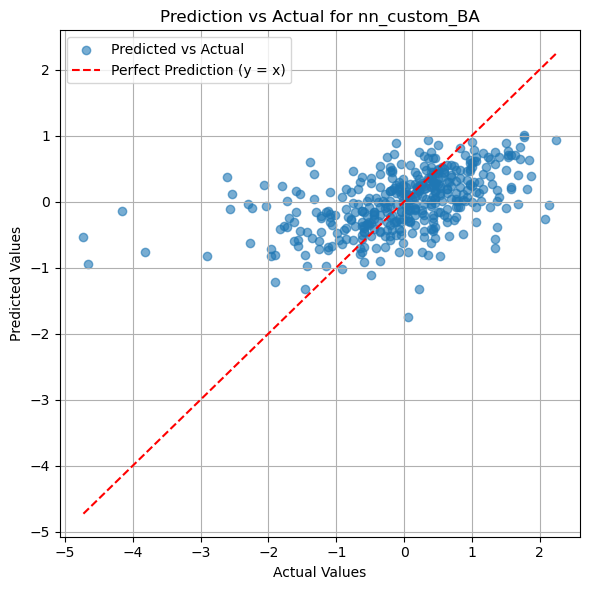

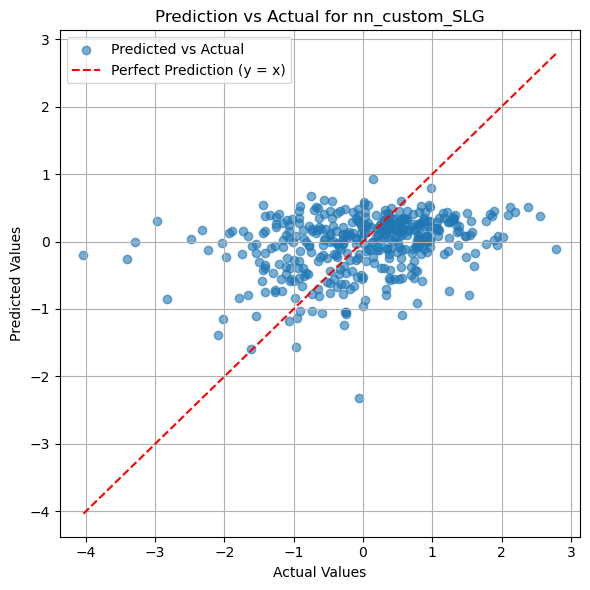

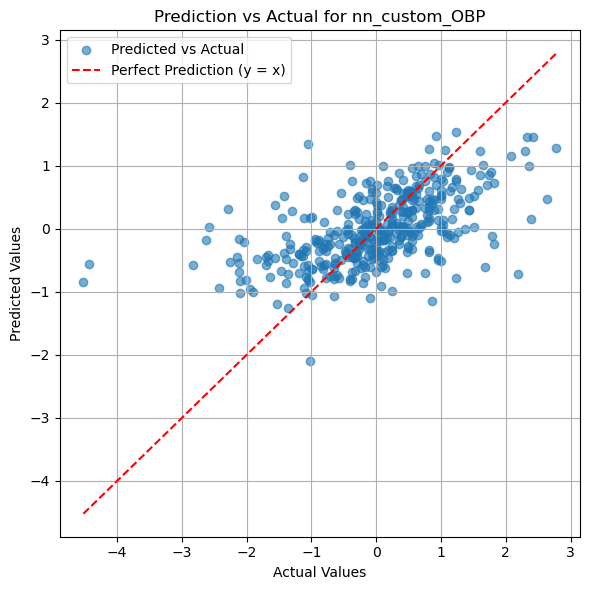

In [ ]:
custom_nn_model_results

#epoch_loss_plot(custom_nn_model_results)

#Rem
plot_prediction_vs_truth(custom_nn_model_results , nn_testingX_dict , nn_testingY_dict)


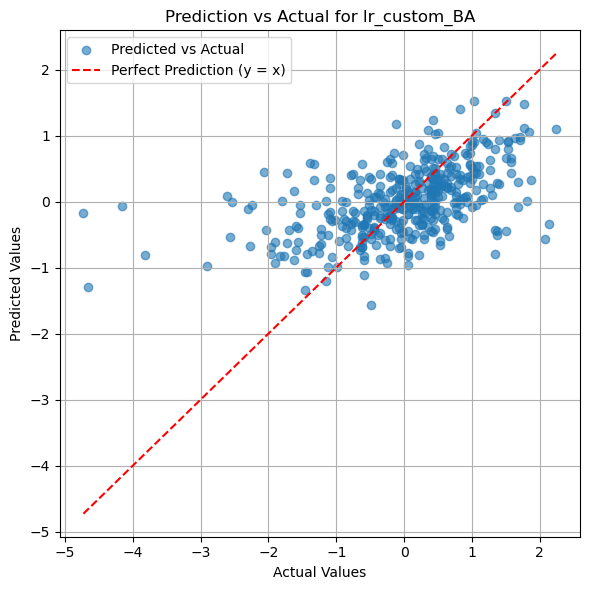

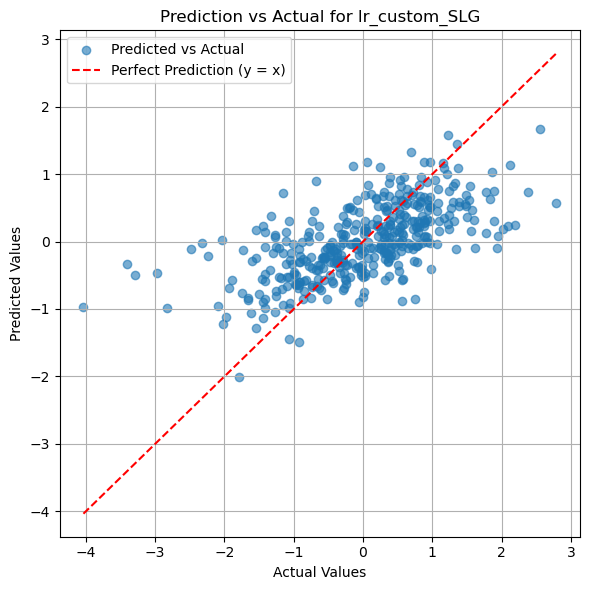

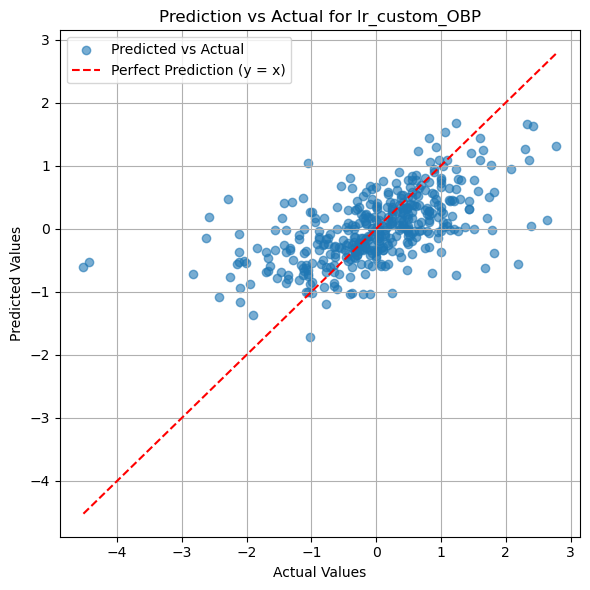

In [102]:
custom_lr_model_results

plot_prediction_vs_truth(custom_lr_model_results , lr_testingX_dict , lr_testingY_dict)


In [ ]:

# Train on the SLG-specific dataset
def create_model():
     nn_model_1 = Sequential([
     Dense(16, activation = 'relu' ,
          kernel_regularizer=regularizers.l2(0.5)),
     Dense(16, activation = 'relu' ,
          kernel_regularizer=regularizers.l2(0.5)),
     Dense(1, activation = 'linear' ) 
     ])

     optimizer = Adam(learning_rate=0.025)

     nn_model_1.compile(optimizer= optimizer , loss = "MSE" )
     return nn_model_1

nn_models_customs = {}

model = create_model()

#lr_scheduler = ReduceLROnPlateau(
    #monitor='val_loss',  # Metric to watch
    #factor=0.5,          # Reduce by this factor
    #patience=5,          # Wait this many epochs with no improvement
    #verbose=1,           # Print updates
    #min_lr=1e-6          # Minimum learning rate
#)

# Train the model, saving history for plotting loss curves
history = model.fit(
    slg_trainingX, 
    slg_trainingY, 
    epochs=500, 
    batch_size=32, 
    validation_split=0.2, 
#     callbacks=[lr_scheduler],  # <-- here
    verbose=1
)

# Evaluate testing MSE
testing_mse = model.evaluate(slg_testingX, slg_testingY, verbose=0)


# Predict and calculate R2 scores
y_pred_train = model.predict(slg_trainingX)


print("NaNs in slg_trainingY:", slg_trainingY.isna().sum())
print("NaNs in predicted training values:", pd.Series(y_pred_train.flatten()).isna().sum())

nn_r2_train = r2_score(slg_trainingY, y_pred_train)

y_pred_test = model.predict(slg_testingX)
nn_r2_test = r2_score(slg_testingY, y_pred_test)

# Save everything to dictionary
nn_models_customs["nn_SLG_custom"] = (model, history, testing_mse, nn_r2_train, nn_r2_test)

Epoch 1/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 2/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: nan
Epoch 3/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 4/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 5/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 6/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 7/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 8/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 9/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 11/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 12/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 13/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 409
'y' sizes: 2200


In [ ]:
nn_models_customs["nn_SLG_custom"]


#epoch_loss_plot(nn_models_customs)

(<Sequential name=sequential_109, built=True>,
 0.8015825152397156,
 0.21970677375793457,
 0.24335432052612305)

In [ ]:
#Model4 LR on nomr data 

#for some reason this made the model worse 



n_models = {}

for feature in trainingX.columns: 
    name = f"lr_{feature}"
    model = LinearRegression().fit(n_trainingX,n_trainingY[feature])
    n_models[name] = model 


n_model_results = { }

for feature in trainingX.columns:
#models["lr_G"].score(testingX, testingY["G"])
    name = f"lr_{feature}"
    train_score = n_models[name].score(n_trainingX, n_trainingY[feature]) 
    testing_score = n_models[name].score(n_testingX , n_testingY[feature])
    n_model_results[name] = (train_score , testing_score)
#models[]
n_model_results


{'lr_G': (0.2902981734178113, 0.3316030127533728),
 'lr_PA': (0.3002031438195256, 0.33467261588136654),
 'lr_AB': (0.30106255328310605, 0.33537498319145254),
 'lr_R': (0.2963178721786126, 0.3231598142122959),
 'lr_H': (0.30434075284355333, 0.3369896065415028),
 'lr_2B': (0.2925289241070054, 0.3152137330189865),
 'lr_3B': (0.2814875327363633, 0.28017825846953404),
 'lr_HR': (0.25357035875906575, 0.25919492809167133),
 'lr_RBI': (0.282548782603006, 0.3048388543742355),
 'lr_SB': (0.3245647455993447, 0.30245565994240164),
 'lr_CS': (0.31240187306599954, 0.3096375671795263),
 'lr_BB': (0.30209186376668173, 0.331158578148977),
 'lr_SO': (0.2422396440530724, 0.27516918334318863),
 'lr_BA': (0.28995761171768153, 0.2737855504314668),
 'lr_OBP': (0.3253444008046813, 0.3429744898821664),
 'lr_SLG': (0.32940787836443874, 0.3795371720388293),
 'lr_HBP': (0.2208420058751811, 0.26373592994458284),
 'lr_SH': (0.2292283703980561, 0.15381642493205394),
 'lr_SF': (0.2791569911318823, 0.30382319990882645

In [ ]:



def create_nn_model():
     nn_model_1 = Sequential([
     Dense(16, activation = 'relu' ,
          kernel_regularizer=regularizers.l2(0.5)),
     Dense(16, activation = 'relu' ,
          kernel_regularizer=regularizers.l2(0.5)),
     Dense(1, activation = 'linear' ) 
     ])


     nn_model_1.compile(optimizer= 'adam' , loss = "MSE" )
     return nn_model_1

feature_subset = ['G' ,'AB' , 'RBI', 'BA' ,  'OBP' , 'SLG']
nn_models = {}
for feature in feature_subset: 
     name = f"nn_{feature}" 
     model = create_nn_model()

     #training model, saving history for training/validation loss plot
     history = model.fit(n_trainingX, n_trainingY[feature], epochs=50, batch_size=16, validation_split=0.2 , verbose =0)

     #calculating testing loss.
     testing_mse = model.evaluate(n_testingX, n_testingY[feature], verbose=0)


     #for calculating R2 score
     y_pred_train = model.predict(n_trainingX)
     nn_r2_train = r2_score(n_trainingY[feature] , y_pred_train )
     
     y_pred_test= model.predict(n_testingX)
     nn_r2_test = r2_score(n_testingY[feature] , y_pred_test)


     nn_models[name] = (model, history , testing_mse ,  nn_r2_train , nn_r2_test )



69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
#nn_models  




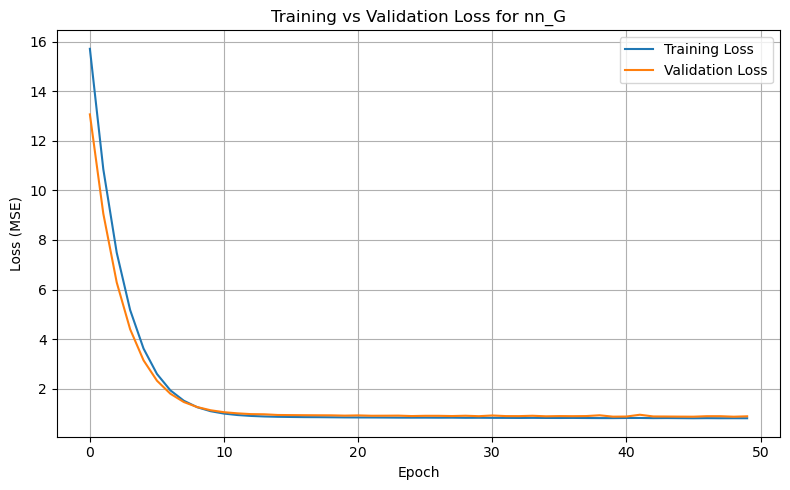

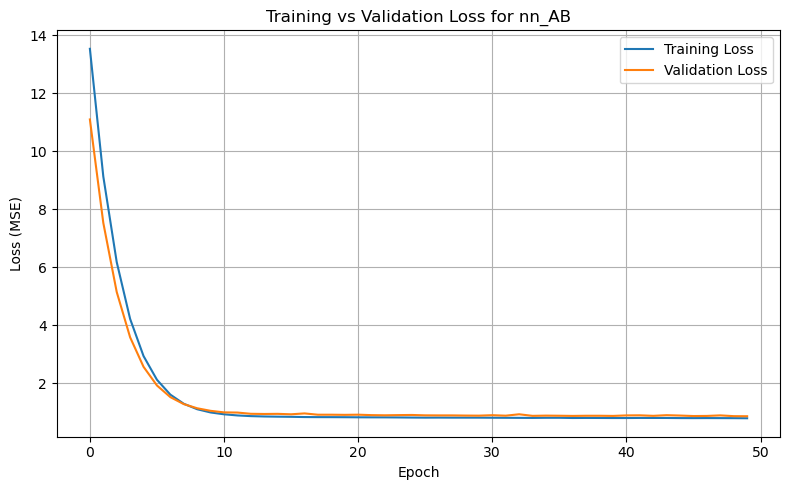

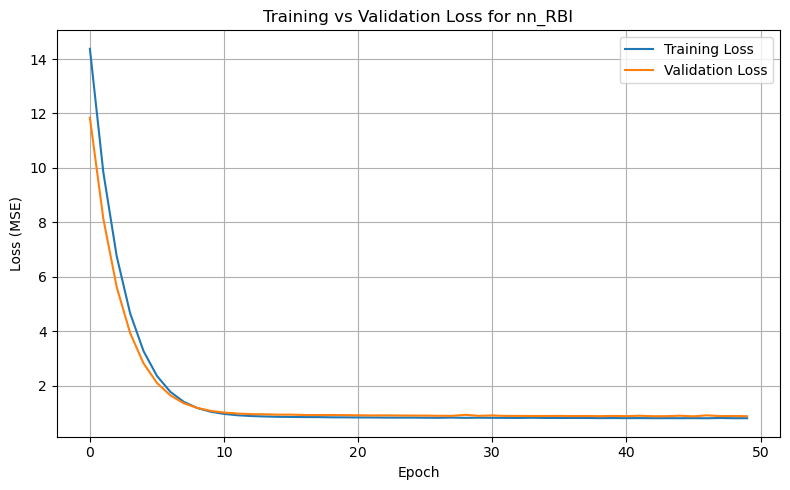

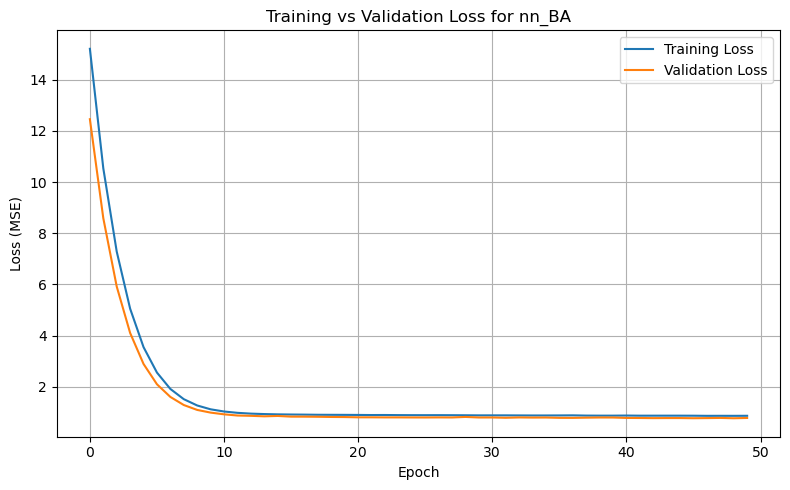

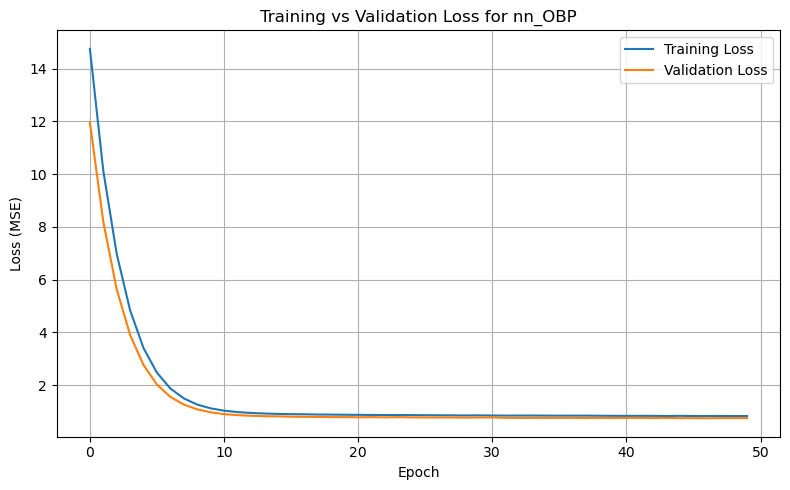

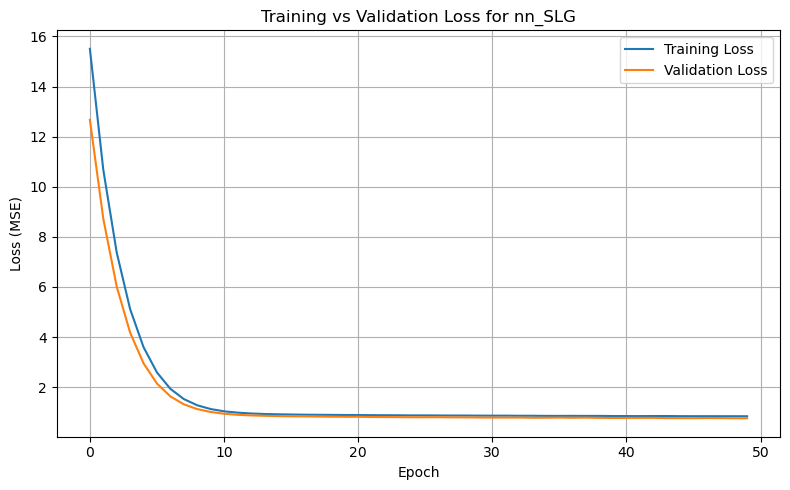

In [ ]:
epoch_loss_plot(nn_models)

In [ ]:
#Examining R2 score 
nn_models




{'nn_G': (<Sequential name=sequential_67, built=True>,
  0.774787187576294,
  0.2521245270065773,
  0.2873527685071825),
 'nn_AB': (<Sequential name=sequential_68, built=True>,
  0.7675438523292542,
  0.2756296616029127,
  0.3122461459530206),
 'nn_RBI': (<Sequential name=sequential_69, built=True>,
  0.8024479150772095,
  0.23987708863552992,
  0.2688881480276222),
 'nn_BA': (<Sequential name=sequential_70, built=True>,
  0.8185650706291199,
  0.24441416504901992,
  0.27143164577598955),
 'nn_OBP': (<Sequential name=sequential_71, built=True>,
  0.7713987827301025,
  0.29989331639680605,
  0.33059838446223944),
 'nn_SLG': (<Sequential name=sequential_72, built=True>,
  0.7694350481033325,
  0.277585666093737,
  0.3269872284128805)}

In [ ]:
#Lets try to not predict an entire career but just the stats for the first season in the majorss

#b_stats.columns 




Index(['Player Name', 'Age', 'AgeDif', 'Tm', 'Lg', 'Lev', 'Aff', 'G', 'PA',
       'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA',
       'OBP', 'SLG', 'OPS', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB'],
      dtype='object')

In [ ]:
#attempt at regression for only the first major season 

#Filter for the first instance of AL or NL in a player's career
first_majors_season = b_stats[(b_stats["Lg"] == "AL")  | (b_stats["Lg"] == "NL")].groupby("Player Name").head(1).reset_index(drop=True)

#Apply the 
_majminoMask = data["Player Name"].value_counts() > 1
tmp_names =  _majminoMask[_majminoMask].index.to_list()
first_majors_season = first_majors_season[first_majors_season["Player Name"].isin(tmp_names)]
#Keep first column of names for checking between datasets later on 
tmp_col = first_majors_season.iloc[ : , :1 ]

#Make sure numerical column types are numeric 
fms_numeric = first_majors_season.iloc[ : , 7: ].map(lambda x: pd.to_numeric(x)) #Start at the 7th column 


#clean NAs in the dataset
fms_cleaned = na_cleaner(fms_numeric) 


fms_cleaned = pd.concat([tmp_col ,fms_cleaned] , axis =1 )
#fms_cleaned.iloc



G has NaN values: False
PA has NaN values: False
AB has NaN values: False
R has NaN values: False
H has NaN values: False
2B has NaN values: False
3B has NaN values: False
HR has NaN values: False
RBI has NaN values: False
SB has NaN values: False
CS has NaN values: False
BB has NaN values: False
SO has NaN values: False
BA has NaN values: True
    BA has 15 nans
OBP has NaN values: True
    OBP has 14 nans
SLG has NaN values: True
    SLG has 15 nans
HBP has NaN values: False
SH has NaN values: False
SF has NaN values: False
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due

/var/folders/y1/wk4cryk10gs66qhp2q7w_4n40000gn/T/ipykernel_89730/2857841401.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return (hits +  bb + hbp)/(ab + bb + hbp + sf)
/var/folders/y1/wk4cryk10gs66qhp2q7w_4n40000gn/T/ipykernel_89730/2857841401.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return (hits - b2 -b3  + 2*b2 +  3*b3 + 4*hr)/(ab)
/var/folders/y1/wk4cryk10gs66qhp2q7w_4n40000gn/T/ipykernel_89730/2857841401.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return (hits - b2 -b3  + 2*b2 +  3*b3 + 4*hr)/(ab)
/var/folders/y1/wk4cryk10gs66qhp2q7w_4n40000gn/T/ipykernel_89730/2857841401.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return (hits/ab)


In [ ]:
#fms_cleaned

,Player Name,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,HBP,SH,SF
0,Wade Boggs,104,381,338,51,118,14,1,5,44,1,0,35,21,0.349,0.406,0.441,0,4,4
1,Dwight Evans,18,64,57,2,15,3,1,1,6,0,0,7,13,0.263,0.344,0.404,0,0,0
2,Kirby Puckett,128,583,557,63,165,12,5,0,31,14,7,16,69,0.296,0.320,0.336,4,4,2
3,Don Mattingly,7,13,12,0,2,0,0,0,1,0,0,0,1,0.167,0.154,0.167,0,0,1
4,Bill Buckner,1,1,1,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2607,Mason McCoy,6,1,1,2,0,0,0,0,0,0,0,0,1,0.000,0.000,0.000,0,0,0
2608,Chandler Seagle,1,1,1,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0,0,0
2609,Mark Kolozsvary,10,21,20,3,4,2,0,1,3,0,0,1,9,0.200,0.238,0.450,0,0,0
2610,José Rodríguez,1,0,0,1,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0,0,0


In [ ]:
#Minors.loc[fms_cleaned.index]




#fms_names = first_majors_season.loc[fms_cleaned.index, "Player Name"].to_list()

#Have to do this because the fms index is different than the minors index.
#X2 = Minors[Minors['Player Name'].isin(fms_names)]


#Minors
#tmp_names = first_majors_season.iloc[fms_cleaned.index]["Player Name"].to_list()

tmp_X2 = data[data["Lev"] == "Minors" ]
tmp_column = tmp_X2.iloc[: , :1]
X2_cleaned = na_cleaner(tmp_X2.iloc[ : ,2:].map(lambda x: pd.to_numeric(x)))

X2_cleaned= pd.concat([tmp_column , X2_cleaned] , axis =1 )
#fms_cleaned


X2_cleaned
#final_data.iloc[1::2].drop(["IBB" , "GDP" , "OPS" , "TB"], axis= 1)



 # Use the mask on the given array to filter for only true values (with both major and minor league data. )
#hardcode take away the values that have no matching 
#uneven_names = ["Alexei Ramírez" , "Ichiro Suzuki" , "Bob Horner"]



G has NaN values: False
PA has NaN values: False
AB has NaN values: False
R has NaN values: False
H has NaN values: False
2B has NaN values: False
3B has NaN values: False
HR has NaN values: False
RBI has NaN values: False
SB has NaN values: False
CS has NaN values: False
BB has NaN values: False
SO has NaN values: False
BA has NaN values: True
    BA has 35 nans
OBP has NaN values: True
    OBP has 36 nans
SLG has NaN values: True
    SLG has 35 nans
HBP has NaN values: False
SH has NaN values: False
SF has NaN values: False
G has NaN values: False
PA has NaN values: False
AB has NaN values: False
R has NaN values: False
H has NaN values: False
2B has NaN values: False
3B has NaN values: False
HR has NaN values: False
RBI has NaN values: False
SB has NaN values: False
CS has NaN values: False
BB has NaN values: False
SO has NaN values: False
BA has NaN values: False
OBP has NaN values: False
SLG has NaN values: False
HBP has NaN values: False
SH has NaN values: False
SF has NaN values

,Player Name,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,HBP,SH,SF
1,Wade Boggs,662,2680,2277,333,724,112,8,9,248,29,20,366,149,0.318,0.412,0.386,8,17,12
3,Dwight Evans,404,1624,1353,235,390,60,25,37,238,9,7,235,281,0.288,0.394,0.452,12,5,19
5,Kirby Puckett,224,996,903,179,298,46,10,13,137,99,17,75,103,0.330,0.382,0.446,5,6,7
7,Don Mattingly,500,2122,1842,288,612,112,16,37,346,17,16,232,132,0.332,0.403,0.471,8,9,31
9,Bill Buckner,281,1192,1121,197,368,51,14,16,192,49,13,46,66,0.328,0.352,0.442,3,6,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,Mason McCoy,767,3228,2865,422,737,142,37,56,345,115,24,303,737,0.257,0.330,0.391,18,17,25
5211,Chandler Seagle,325,1155,1024,116,206,55,1,10,94,10,7,77,332,0.201,0.272,0.286,26,19,9
5213,Mark Kolozsvary,352,1294,1103,156,231,59,3,27,123,7,4,128,373,0.209,0.322,0.342,56,3,4
5215,José Rodríguez,465,2080,1940,317,547,96,18,61,253,136,37,115,341,0.282,0.324,0.444,10,4,11


In [ ]:
print(X2_cleaned["Player Name"].to_list() == fms_cleaned["Player Name"].to_list())

#Create training and testing split 

X2 = X2_cleaned.iloc[:,1:].copy().reset_index(drop=True) 
Y2=  fms_cleaned.copy().iloc[:,1:].reset_index(drop=True) 

#print(X2)
print(Y2)
#na_check(Y2)
#na_check(X2)
trainingX2 = X2.sample(n = 2200, random_state=1)

trainingY2 = Y2.loc[trainingX.index]

testingX2= X2.drop(trainingX.index)

testingY2 = Y2.drop(trainingX.index)

print(np.where(np.isinf(trainingY2).values))
np.isinf(trainingY2).values

trainingY2.iloc[1428,:]  = 0 

True
        G   PA   AB   R    H  2B  3B  HR  RBI  SB  CS  BB  SO     BA    OBP  \
0     104  381  338  51  118  14   1   5   44   1   0  35  21  0.349  0.406   
1      18   64   57   2   15   3   1   1    6   0   0   7  13  0.263  0.344   
2     128  583  557  63  165  12   5   0   31  14   7  16  69  0.296  0.320   
3       7   13   12   0    2   0   0   0    1   0   0   0   1  0.167  0.154   
4       1    1    1   0    0   0   0   0    0   0   0   0   0  0.000  0.000   
...   ...  ...  ...  ..  ...  ..  ..  ..  ...  ..  ..  ..  ..    ...    ...   
2604    6    1    1   2    0   0   0   0    0   0   0   0   1  0.000  0.000   
2605    1    1    1   0    0   0   0   0    0   0   0   0   0  0.000  0.000   
2606   10   21   20   3    4   2   0   1    3   0   0   1   9  0.200  0.238   
2607    1    0    0   1    0   0   0   0    0   0   0   0   0  0.000  0.000   
2608   33  135  116  19   34   6   1   5   17   2   0  15  29  0.293  0.393   

        SLG  HBP  SH  SF  
0     0.441    0   

In [ ]:
#na_check(trainingX2)


#Linear Regression on first major season data as a target

_models = {}

for feature in trainingX2.columns: 
    name = f"lr_{feature}"
    model = LinearRegression().fit(trainingX2,trainingY2[feature])
    fms_models[name] = model 

fms_model_results = { }

for feature in trainingX2.columns:
#models["lr_G"].score(testingX, testingY["G"])
    name = f"lr_{feature}"
    train_score = fms_models[name].score(trainingX2, trainingY2[feature]) 
    testing_score = fms_models[name].score(testingX2 , testingY2[feature])
    fms_model_results[name] = (train_score , testing_score)
#models[]
fms_model_results





{'lr_G': (0.10457828198585872, 0.06585410149985316),
 'lr_PA': (0.1338296429363044, 0.10983618203430379),
 'lr_AB': (0.1310119211582914, 0.10816928094344869),
 'lr_R': (0.13472334280211096, 0.12753064154816218),
 'lr_H': (0.12900866101325836, 0.12094709453885244),
 'lr_2B': (0.12608669056769128, 0.11479783396988652),
 'lr_3B': (0.09047548727328403, 0.10998437493863411),
 'lr_HR': (0.147920629877337, 0.11847251748188059),
 'lr_RBI': (0.1334349075970438, 0.11815976496074398),
 'lr_SB': (0.1627138511701136, 0.1477498296932982),
 'lr_CS': (0.12189256672281801, 0.12058521943795952),
 'lr_BB': (0.17559732479613732, 0.13995807211471345),
 'lr_SO': (0.1599305388105492, 0.11149628463601435),
 'lr_BA': (0.02831996127270897, 0.029283556737845884),
 'lr_OBP': (0.04403084082471109, 0.04578246701695121),
 'lr_SLG': (0.05742648449131582, -0.0012302897344320662),
 'lr_HBP': (0.11990945354541993, 0.12817940040093223),
 'lr_SH': (0.08837340569843499, 0.06492998943864192),
 'lr_SF': (0.08771467642095665,

In [ ]:
from sklearn.metrics import mean_squared_error
hp = 0.0

fms_models_rr = {}


for feature in trainingX.columns: 
    name = f"lr_{feature}"
    model = Ridge(alpha = hp , solver = "svd"  )
    model.fit(trainingX2,trainingY2[feature]) 
    fms_models_rr[name] = model 


fms_model_rr_results = { }

for feature in trainingX.columns:
#models["lr_G"].score(testingX, testingY["G"])
    name = f"lr_{feature}"
    train_score = fms_models_rr[name].score(trainingX2, trainingY2[feature]) 
    testing_score = fms_models_rr[name].score(testingX2 , testingY2[feature])
    fms_model_rr_results[name] = (train_score , testing_score)
#models[]

fms_model_rr_results

{'lr_G': (0.10448083965879562, 0.06491798742731847),
 'lr_PA': (0.1340268015929884, 0.11001866910230962),
 'lr_AB': (0.1307992652895228, 0.10860201285686244),
 'lr_R': (0.1345671170624767, 0.12551495836235937),
 'lr_H': (0.12887495873582389, 0.12052362111651749),
 'lr_2B': (0.12623226063827386, 0.11410638985337407),
 'lr_3B': (0.09022595953933388, 0.10998785055294369),
 'lr_HR': (0.14783459824564404, 0.11730371507528292),
 'lr_RBI': (0.13301870887227973, 0.11868405060050446),
 'lr_SB': (0.16271387490384936, 0.1479354506923073),
 'lr_CS': (0.12183781414976269, 0.12042187754860145),
 'lr_BB': (0.17499434095619626, 0.13910511690921867),
 'lr_SO': (0.15976307038454318, 0.11092940786468963),
 'lr_BA': (0.027927710151575358, 0.030707605505237545),
 'lr_OBP': (0.04405690675791529, 0.045670341933238934),
 'lr_SLG': (0.05681455462000218, 0.0003017020635709411),
 'lr_HBP': (0.11958344459765291, 0.12748681870284595),
 'lr_SH': (0.08781166652602324, 0.0660520789765805),
 'lr_SF': (0.08771461006373

In [ ]:
hp_mse_training = []
hp_mse_validation = []

hps = np.linspace(0 , 5 , 100 ) #range for hyperparameters 
validationX2 =  trainingX2.sample(100, random_state=2)

validationY2 = trainingY2.loc[validationX2.index]

hp_trainingX2 = trainingX2.drop(validationX2.index)

hp_trainingY2= trainingY2.drop(validationX2.index)


for hp in hps:   
    model = Ridge(alpha = hp , solver = "svd"  )
    model.fit(trainingX2,trainingY2["H"]) 
    y_training_pred = model.predict(trainingX2) 
    y_validation_pred = model.predict(validationX2)
    hp_mse_training.append(mean_squared_error(trainingY2[feature],y_training_pred ))
    hp_mse_validation.append(mean_squared_error(validationY2[feature],y_validation_pred ))
#    hp_mse_training.append(mean_squared_error(trainingY2[feature],y_training_pred ))


print(max(hp_mse_validation))
print(min(hp_mse_validation))
print(hps[hp_mse_validation.index(min(hp_mse_validation))]) 
#print(np.median(hp_msvalidation))

trainingX.columns

894.1025383149192
869.6785443981287
0.0


Index(['G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB',
       'SO', 'BA', 'OBP', 'SLG', 'HBP', 'SH', 'SF'],
      dtype='object')

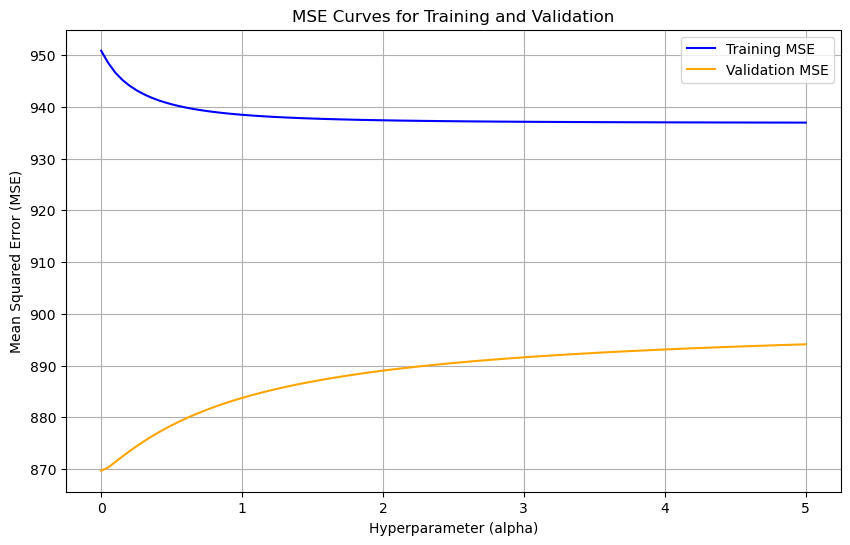

In [ ]:

# Plotting the MSE curves
plt.figure(figsize=(10, 6))
plt.plot(hps, hp_mse_training, label='Training MSE', color='blue')
plt.plot(hps, hp_mse_validation, label='Validation MSE', color='orange')
plt.title('MSE Curves for Training and Validation')
plt.xlabel('Hyperparameter (alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid()
plt.show()



In [ ]:
three_majors_season = b_stats[(b_stats["Lg"] == "AL")  | (b_stats["Lg"] == "NL")].groupby("Player Name").head(3).reset_index(drop=True)




#Apply the 
_majminoMask = data["Player Name"].value_counts() > 1
tmp_names =  _majminoMask[_majminoMask].index.to_list()
three_majors_season = three_majors_season[three_majors_season["Player Name"].isin(tmp_names)]
#Keep first column of names for checking between datasets later on 

tmp_col = three_majors_season.iloc[ : , :1]
#Make sure numerical column types are numeric 
tms_numeric = three_majors_season.iloc[ : , 7: ].map(lambda x: pd.to_numeric(x)) #Start at the 7th column 
#tms

tms_cleaned = na_cleaner(tms_numeric) 
tms_cleaned = pd.concat([tmp_col ,tms_cleaned] , axis =1 )



#clean NAs in the dataset


#fms_cleaned.iloc





G has NaN values: False
PA has NaN values: False
AB has NaN values: False
R has NaN values: False
H has NaN values: False
2B has NaN values: False
3B has NaN values: False
HR has NaN values: False
RBI has NaN values: False
SB has NaN values: False
CS has NaN values: False
BB has NaN values: False
SO has NaN values: False
BA has NaN values: True
    BA has 32 nans
OBP has NaN values: True
    OBP has 31 nans
SLG has NaN values: True
    SLG has 32 nans
HBP has NaN values: False
SH has NaN values: False
SF has NaN values: False
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due to division by 0
Error due

/var/folders/y1/wk4cryk10gs66qhp2q7w_4n40000gn/T/ipykernel_2794/2179314140.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return (hits +  bb + hbp)/(ab + bb + hbp + sf)
/var/folders/y1/wk4cryk10gs66qhp2q7w_4n40000gn/T/ipykernel_2794/2179314140.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return (b1 + 2*b2 +  3*b3 + 4*H)/(ab)
/var/folders/y1/wk4cryk10gs66qhp2q7w_4n40000gn/T/ipykernel_2794/2179314140.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return (b1 + 2*b2 +  3*b3 + 4*H)/(ab)
/var/folders/y1/wk4cryk10gs66qhp2q7w_4n40000gn/T/ipykernel_2794/2179314140.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return (hits/ab)


In [ ]:
#print(tms_cleaned.copy().groupby("Player Name" , as_index=False).mean())


Object `pd.mean()` not found.


In [ ]:
#Make a Visualization

#Resolution Plots

def resolution(true_val , predict_val): 

    reso = (true_val - predict_val)
    
    return reso

def model_reso(model, X , Y): 

    
    Y_hat = model.predict(X)
    reso = resolution(Y ,Y_hat)

    return reso

2291.9575239691676
9919.541541963777
1439.5415419637768
-9.964023355726706
-9.861023355726706
-9.794023355726706


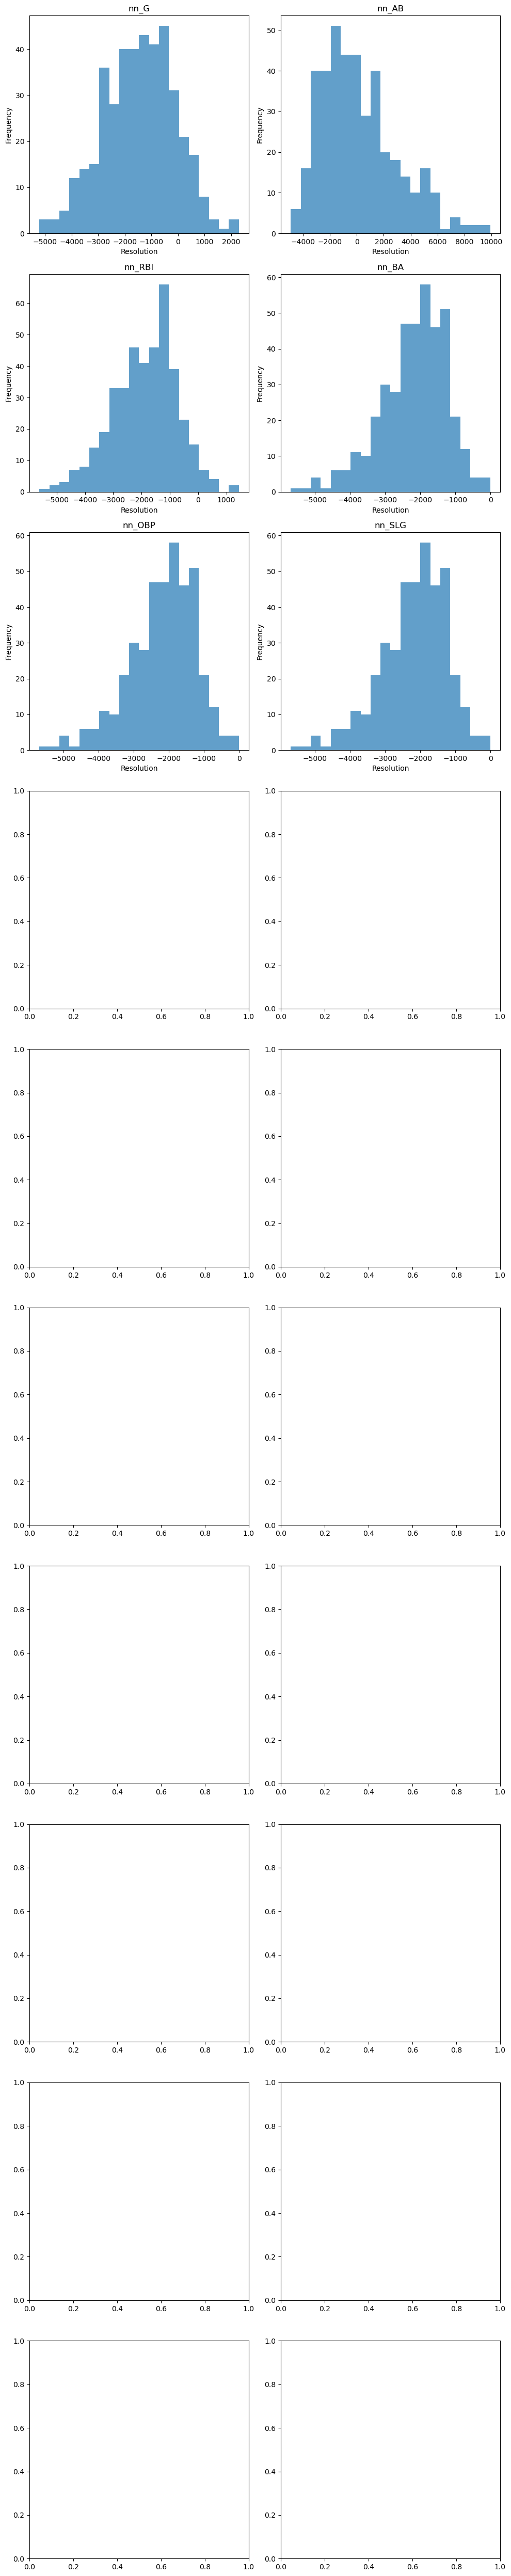

In [ ]:
#model_reso(modl)
#name, mod = n_models.items()
#n_models.items()
#print(mod)

fig, axes = plt.subplots(10, 2, figsize=(10, 50))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

for i, (name, model) in enumerate(n_models.items()):
    feature = name[3:]  # Extract feature name
    reso = model_reso(model, testingX, testingY[feature])  # Get resolution
    print(max(reso))
    # Plot histogram in the corresponding subplot
    axes[i].hist(reso, bins=20, alpha=0.7)  # You can adjust the number of bins and alpha
    axes[i].set_title(name)  # Set the title of the subplot
    axes[i].set_xlabel('Resolution')  # Set x-axis label
    axes[i].set_ylabel('Frequency')  # Set y-axis label
#    axes[i].set_xlim(-10, 10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()